# Non profiled attack (see Section 6)

## Outline

[Content](#content)

[Prerequisite packages and settings](#prerequisite-packages-and-settings)

[Step 1: Traces generation and preprocessing](#step-1)

- [Step 1.1: Traces generation](#step-11)

- [Step 1.2: Preprocessing](#step-12)

[Step 2: Attack phase](#step-2)

## Content <a class='anchor' id='content'></a>

In this notebook, we propose to conduct a non profiled attack using NPcVAE-OSM, following the attack strategy provided in Section 5.2.

To do so, we propose in this notebook to attack simulated traces on a subset of key hypotheses. 

We first generate a set of attack traces *i.e.* with a fixed key on which we apply preprocessing techniques, namely standardization. 

This notebook is provided as an example. In particular, users are free to adapt this notebook to suit the dataset and key hypotheses they want to target.

In addition, we draw users' attention to the fact that, to ensure proper attack execution, lines $138$, $140$, $262$ and $264$ in $\texttt{non\_profiled\_attack.py}$ file must also be adapted to the targeted dataset.

## Prerequisite packages and settings <a class='anchor' id='prerequisite-packages-and-settings'></a>
Here are the Python packages and settings needed to run properly this notebook.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

from NPcVAE_OSM_utils.generate_traces import *
from NPcVAE_OSM_utils.NPcVAE_OSM_model import *
from NPcVAE_OSM_utils.NPcVAE_OSM_tools import *
from NPcVAE_OSM_utils.non_profiled_attack import *
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.rcParams['text.usetex'] = True

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Step 1: Traces generation and preprocessing <a class='anchor' id='step-1'></a>

### Step 1.1: Traces generation <a class='anchor' id='step-11'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{generate\_traces.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
The targeted byte is $0$ and the key is fixed. 

We set the seed to $42$ to have reproductible results. 

In [2]:
# Traces generation
targeted_byte = 0

attack_traces, attack_plaintexts, attack_keys, attack_targeted_variables, attack_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, sigmas=np.array([1,5,10]),\
                                                                                                              targeted_byte=targeted_byte, isotropic_noise=False, scenario='scenario_4',\
                                                                                                              key_fixed=True, seed=42)

print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

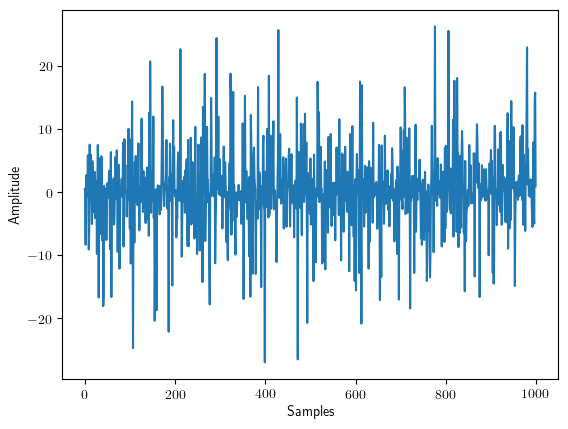

In [3]:
# Plot of a trace
plt.plot(attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 1.2: Preprocessing <a class='anchor' id='step-12'></a>

Then, we apply on these traces preprocessing techniques. Specifically, we apply Standardization (see Section 6.1).

In [4]:
from sklearn.preprocessing import StandardScaler

max_scaler = StandardScaler()

attack_traces_rescaled = max_scaler.fit_transform(attack_traces).astype('float32')

The amplitude of traces is rescaled.

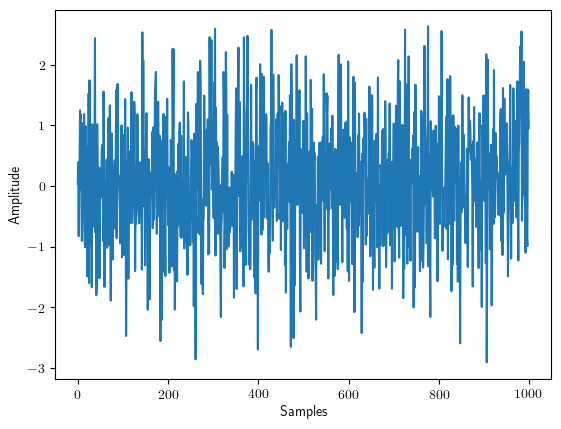

In [5]:
# Plot of a rescaled trace
plt.plot(attack_traces_rescaled[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Once traces are rescaled, one can proceed to the attack phase.

## Step 2: Attack phase <a class='anchor' id='step-2'></a>

In this example we propose to conduct $\texttt{total\_nb\_attack}=5$ independent attacks considering $100$, $500$ and $750$ traces.

To conduct each attack, we need to instanciate a NPcVAE-OSM model. 
The instanciation of the latter is included in $\texttt{run\_averaged\_attacks}$ function routine.
In this example, we consider a learning rate, batch size and number of epochs of respectively $0.01$, $16$ and $50$.

The training is conducted for a subset of key hypotheses specified by the variable $\texttt{keys\_subset}$ and without any assumption on leakage model *i.e* we conduct attacks on full basis ($\texttt{max\_nb\_monomials\_interactions}=8$ and $\texttt{len\_basis}=256$).
Moreover, training is done on pools of traces of size $100$, $500$ and $750$.

As for traces generation, to enable reproductible results, we set the seeds related to our model to fixed values. In this case, we choose $\texttt{seeds}=[42,42]$.

In [6]:
total_nb_attack = 5
nb_key_hypotheses = 5
traces_number = np.array([100, 500, 750])
keys_subset = np.array([0, 1, 2, attack_keys[targeted_byte], 255])
nb_samples = attack_traces_rescaled.shape[1]
learning_rate = 0.01
max_nb_monomials_interactions, len_basis = 8, 256
batch_size = 16
epochs = 50

# Attack phase: models training
run_averaged_attacks(total_nb_attack, traces_number, attack_traces_rescaled, attack_plaintexts[:, targeted_byte], 0, sbox_vectorized, len_basis, max_nb_monomials_interactions, \
                     nb_key_hypotheses, "Example_simulations/", 'Example_simulations', learning_rate, epochs, batch_size, keys=keys_subset, is_deterministic=True, seeds=[42,42])

Projections for all key hypotheses done ✅



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



Model created ✅
Epoch 1/50
7/7 [==============================] - 5s 26ms/step - ELBO loss: 1425.7755 - reconstruction_loss: 1421.7272 - kl_loss: 2.6101
Epoch 2/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1373.0874 - reconstruction_loss: 1367.1322 - kl_loss: 6.1657
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1332.6044 - reconstruction_loss: 1327.3627 - kl_loss: 2.4682
Epoch 4/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1302.1507 - reconstruction_loss: 1292.7400 - kl_loss: 0.1875
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1276.7680 - reconstruction_loss: 1262.5005 - kl_loss: 0.6320
Epoch 6/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1253.2550 - reconstruction_loss: 1236.1212 - kl_loss: 0.4162
Epoch 7/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1232.4063 - reconstruction_loss: 1213.0956 - kl_loss: 0.4715
Epoch 8/50
7/7 [=======

7/7 [==============================] - 0s 23ms/step - ELBO loss: 1251.0047 - reconstruction_loss: 1234.9208 - kl_loss: 0.4640
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - ELBO loss: 1229.4054 - reconstruction_loss: 1211.6649 - kl_loss: 0.6009
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - ELBO loss: 1210.0881 - reconstruction_loss: 1191.2002 - kl_loss: 1.3645
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - ELBO loss: 1192.2625 - reconstruction_loss: 1173.0983 - kl_loss: 1.3632
Epoch 10/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1175.9877 - reconstruction_loss: 1157.0017 - kl_loss: 0.9687
Epoch 11/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1161.0480 - reconstruction_loss: 1142.6201 - kl_loss: 0.1136
Epoch 12/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1147.6057 - reconstruction_loss: 1129.7190 - kl_loss: 0.0599
Epoch 13/50
7/7 [==============================] 

7/7 [==============================] - 0s 26ms/step - ELBO loss: 1098.5218 - reconstruction_loss: 1093.2864 - kl_loss: 0.1346
Epoch 16/50
7/7 [==============================] - 0s 27ms/step - ELBO loss: 1088.5122 - reconstruction_loss: 1084.4507 - kl_loss: 0.4430
Epoch 17/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1079.4278 - reconstruction_loss: 1076.4504 - kl_loss: 0.8751
Epoch 18/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1071.1043 - reconstruction_loss: 1069.2095 - kl_loss: 1.0418
Epoch 19/50
7/7 [==============================] - 0s 23ms/step - ELBO loss: 1063.6278 - reconstruction_loss: 1062.6602 - kl_loss: 1.5389
Epoch 20/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1056.7532 - reconstruction_loss: 1056.7415 - kl_loss: 1.6249
Epoch 21/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1050.3915 - reconstruction_loss: 1051.3979 - kl_loss: 1.1683
Epoch 22/50
7/7 [=============================

7/7 [==============================] - 0s 25ms/step - ELBO loss: 1051.2125 - reconstruction_loss: 1044.4523 - kl_loss: 0.3164
Epoch 25/50
7/7 [==============================] - 0s 23ms/step - ELBO loss: 1047.4770 - reconstruction_loss: 1041.0476 - kl_loss: 0.0870
Epoch 26/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1044.1606 - reconstruction_loss: 1037.9884 - kl_loss: 0.0392
Epoch 27/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1041.1916 - reconstruction_loss: 1035.2427 - kl_loss: 0.0248
Epoch 28/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1038.5365 - reconstruction_loss: 1032.7810 - kl_loss: 0.0363
Epoch 29/50
7/7 [==============================] - 0s 23ms/step - ELBO loss: 1036.1568 - reconstruction_loss: 1030.5765 - kl_loss: 0.0361
Epoch 30/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1034.0266 - reconstruction_loss: 1028.6046 - kl_loss: 0.0275
Epoch 31/50
7/7 [=============================

7/7 [==============================] - 0s 26ms/step - ELBO loss: 1038.2233 - reconstruction_loss: 1021.3680 - kl_loss: 0.0815
Epoch 34/50
7/7 [==============================] - 0s 26ms/step - ELBO loss: 1036.8973 - reconstruction_loss: 1020.1008 - kl_loss: 0.1354
Epoch 35/50
7/7 [==============================] - 0s 24ms/step - ELBO loss: 1035.7321 - reconstruction_loss: 1018.9731 - kl_loss: 0.2408
Epoch 36/50
7/7 [==============================] - 0s 26ms/step - ELBO loss: 1034.7271 - reconstruction_loss: 1017.9708 - kl_loss: 0.4558
Epoch 37/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1033.8857 - reconstruction_loss: 1017.0808 - kl_loss: 0.8490
Epoch 38/50
7/7 [==============================] - 0s 25ms/step - ELBO loss: 1033.1944 - reconstruction_loss: 1016.2913 - kl_loss: 1.4177
Epoch 39/50
7/7 [==============================] - 0s 27ms/step - ELBO loss: 1032.5836 - reconstruction_loss: 1015.5917 - kl_loss: 1.9268
Epoch 40/50
7/7 [=============================


 33%|████████████████████████████                                                        | 1/3 [01:08<02:16, 68.39s/it]

Training done for exp n°5 - 100 traces ✅
Training done for 100 traces ✅
Model created ✅
Epoch 1/50
32/32 [==============================] - 4s 24ms/step - ELBO loss: 1424.2181 - reconstruction_loss: 1420.8972 - kl_loss: 2.3254
Epoch 2/50
32/32 [==============================] - 1s 25ms/step - ELBO loss: 1376.0542 - reconstruction_loss: 1375.7123 - kl_loss: 4.7227
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - ELBO loss: 1343.5271 - reconstruction_loss: 1347.9674 - kl_loss: 7.1813
Epoch 4/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1322.8169 - reconstruction_loss: 1326.2205 - kl_loss: 7.0555
Epoch 5/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1306.6482 - reconstruction_loss: 1308.8695 - kl_loss: 7.7141
Epoch 6/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 1293.0841 - reconstruction_loss: 1294.8635 - kl_loss: 4.5116
Epoch 7/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 

32/32 [==============================] - 1s 26ms/step - ELBO loss: 1265.6788 - reconstruction_loss: 1266.4838 - kl_loss: 5.2384
Epoch 9/50
32/32 [==============================] - 1s 25ms/step - ELBO loss: 1256.8776 - reconstruction_loss: 1257.4819 - kl_loss: 4.5088
Epoch 10/50
32/32 [==============================] - 1s 25ms/step - ELBO loss: 1249.4339 - reconstruction_loss: 1249.8347 - kl_loss: 6.2817
Epoch 11/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 1242.7361 - reconstruction_loss: 1243.2971 - kl_loss: 1.9733
Epoch 12/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 1237.1868 - reconstruction_loss: 1237.6761 - kl_loss: 2.2356
Epoch 13/50
32/32 [==============================] - 1s 26ms/step - ELBO loss: 1232.3415 - reconstruction_loss: 1232.8181 - kl_loss: 1.6439
Epoch 14/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 1228.1909 - reconstruction_loss: 1228.6001 - kl_loss: 2.1450
Epoch 15/50
32/32 [==============

32/32 [==============================] - 1s 23ms/step - ELBO loss: 1229.6048 - reconstruction_loss: 1219.7506 - kl_loss: 5.1493
Epoch 17/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1227.2539 - reconstruction_loss: 1217.1179 - kl_loss: 4.1944
Epoch 18/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1225.5213 - reconstruction_loss: 1214.8203 - kl_loss: 1.4772
Epoch 19/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1223.4264 - reconstruction_loss: 1212.8086 - kl_loss: 1.4706
Epoch 20/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1222.0517 - reconstruction_loss: 1211.0437 - kl_loss: 2.0792
Epoch 21/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1220.7756 - reconstruction_loss: 1209.4912 - kl_loss: 2.4784
Epoch 22/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 1219.8005 - reconstruction_loss: 1208.1229 - kl_loss: 3.0553
Epoch 23/50
32/32 [=============

32/32 [==============================] - 1s 23ms/step - ELBO loss: 1216.9564 - reconstruction_loss: 1210.1326 - kl_loss: 3.7326
Epoch 25/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1216.2307 - reconstruction_loss: 1209.2151 - kl_loss: 5.5993
Epoch 26/50
32/32 [==============================] - 1s 22ms/step - ELBO loss: 1217.2804 - reconstruction_loss: 1208.4012 - kl_loss: 8.1784
Epoch 27/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1215.2649 - reconstruction_loss: 1207.6776 - kl_loss: 14.4585
Epoch 28/50
32/32 [==============================] - 1s 25ms/step - ELBO loss: 1230.6122 - reconstruction_loss: 1207.0341 - kl_loss: 25.7141
Epoch 29/50
32/32 [==============================] - 1s 25ms/step - ELBO loss: 1213.7725 - reconstruction_loss: 1206.4613 - kl_loss: 9.0811
Epoch 30/50
32/32 [==============================] - 1s 27ms/step - ELBO loss: 1214.0038 - reconstruction_loss: 1205.9507 - kl_loss: 8.3224
Epoch 31/50
32/32 [===========

32/32 [==============================] - 1s 25ms/step - ELBO loss: 1214.8178 - reconstruction_loss: 1209.2245 - kl_loss: 1.9141
Epoch 33/50
32/32 [==============================] - 1s 24ms/step - ELBO loss: 1214.4667 - reconstruction_loss: 1208.8817 - kl_loss: 1.1455
Epoch 34/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1214.2571 - reconstruction_loss: 1208.5754 - kl_loss: 2.1352
Epoch 35/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1213.9836 - reconstruction_loss: 1208.3019 - kl_loss: 1.4153
Epoch 36/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1213.8409 - reconstruction_loss: 1208.0573 - kl_loss: 2.6847
Epoch 37/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1213.7009 - reconstruction_loss: 1207.8384 - kl_loss: 3.5557
Epoch 38/50
32/32 [==============================] - 1s 23ms/step - ELBO loss: 1213.6847 - reconstruction_loss: 1207.6428 - kl_loss: 4.7964
Epoch 39/50
32/32 [=============


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:41<02:33, 153.57s/it]

Training done for exp n°5 - 500 traces ✅
Training done for 500 traces ✅
Model created ✅
Epoch 1/50
47/47 [==============================] - 5s 23ms/step - ELBO loss: 1421.3929 - reconstruction_loss: 1421.3400 - kl_loss: 2.5135
Epoch 2/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 1378.1647 - reconstruction_loss: 1382.3907 - kl_loss: 3.4989
Epoch 3/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 1349.7711 - reconstruction_loss: 1358.6884 - kl_loss: 0.8286
Epoch 4/50
47/47 [==============================] - 1s 22ms/step - ELBO loss: 1331.6013 - reconstruction_loss: 1340.8257 - kl_loss: 0.3177
Epoch 5/50
47/47 [==============================] - 1s 22ms/step - ELBO loss: 1319.0466 - reconstruction_loss: 1327.1675 - kl_loss: 0.4082
Epoch 6/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 1309.5466 - reconstruction_loss: 1316.5823 - kl_loss: 0.7456
Epoch 7/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 

47/47 [==============================] - 1s 26ms/step - ELBO loss: 1295.9637 - reconstruction_loss: 1298.0720 - kl_loss: 3.9393
Epoch 9/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1292.3842 - reconstruction_loss: 1292.4259 - kl_loss: 5.0991
Epoch 10/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 1287.1770 - reconstruction_loss: 1287.8428 - kl_loss: 3.5777
Epoch 11/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1283.1538 - reconstruction_loss: 1284.0912 - kl_loss: 2.7003
Epoch 12/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1279.3831 - reconstruction_loss: 1280.9951 - kl_loss: 1.6814
Epoch 13/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1276.8292 - reconstruction_loss: 1278.4210 - kl_loss: 1.3523
Epoch 14/50
47/47 [==============================] - 1s 26ms/step - ELBO loss: 1274.6954 - reconstruction_loss: 1276.2665 - kl_loss: 1.1377
Epoch 15/50
47/47 [==============

47/47 [==============================] - 1s 26ms/step - ELBO loss: 1270.8991 - reconstruction_loss: 1272.1161 - kl_loss: 0.8439
Epoch 17/50
47/47 [==============================] - 1s 26ms/step - ELBO loss: 1269.9305 - reconstruction_loss: 1270.8484 - kl_loss: 1.0562
Epoch 18/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1269.1365 - reconstruction_loss: 1269.7614 - kl_loss: 1.2983
Epoch 19/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1268.6627 - reconstruction_loss: 1268.8245 - kl_loss: 1.9355
Epoch 20/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1268.2744 - reconstruction_loss: 1268.0132 - kl_loss: 2.4593
Epoch 21/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1268.2397 - reconstruction_loss: 1267.3081 - kl_loss: 3.5508
Epoch 22/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1267.8761 - reconstruction_loss: 1266.6923 - kl_loss: 3.7589
Epoch 23/50
47/47 [=============

47/47 [==============================] - 1s 25ms/step - ELBO loss: 1264.5776 - reconstruction_loss: 1268.3909 - kl_loss: 3.4159
Epoch 25/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 1263.9152 - reconstruction_loss: 1267.9447 - kl_loss: 2.6717
Epoch 26/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1262.7346 - reconstruction_loss: 1267.5488 - kl_loss: 1.6497
Epoch 27/50
47/47 [==============================] - 1s 23ms/step - ELBO loss: 1262.2190 - reconstruction_loss: 1267.1969 - kl_loss: 1.4863
Epoch 28/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1261.5673 - reconstruction_loss: 1266.8829 - kl_loss: 1.2602
Epoch 29/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1261.2600 - reconstruction_loss: 1266.6028 - kl_loss: 1.2909
Epoch 30/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1260.9096 - reconstruction_loss: 1266.3528 - kl_loss: 1.3078
Epoch 31/50
47/47 [=============

47/47 [==============================] - 1s 23ms/step - ELBO loss: 1269.1621 - reconstruction_loss: 1267.4347 - kl_loss: 1.3356
Epoch 33/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1269.2301 - reconstruction_loss: 1267.2786 - kl_loss: 1.5418
Epoch 34/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1269.3161 - reconstruction_loss: 1267.1394 - kl_loss: 1.8154
Epoch 35/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1269.5602 - reconstruction_loss: 1267.0143 - kl_loss: 2.1666
Epoch 36/50
47/47 [==============================] - 1s 26ms/step - ELBO loss: 1269.8008 - reconstruction_loss: 1266.9027 - kl_loss: 2.5655
Epoch 37/50
47/47 [==============================] - 1s 24ms/step - ELBO loss: 1270.1448 - reconstruction_loss: 1266.8026 - kl_loss: 2.9535
Epoch 38/50
47/47 [==============================] - 1s 25ms/step - ELBO loss: 1270.3444 - reconstruction_loss: 1266.7134 - kl_loss: 3.2552
Epoch 39/50
47/47 [=============

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [09:52<00:00, 197.55s/it]

Training done for exp n°5 - 750 traces ✅
Training done for 750 traces ✅
Training done ✅


Once models are trained for each attack, the attack strategy explained in Section 5.2 of our paper is then performed independently for each attack within the same function *i.e.* $\texttt{averaged\_rank}$ function.

In [7]:
# Attack phase: Computation of the averaged rank
_, decoder_results = averaged_rank(total_nb_attack, traces_number, attack_keys[targeted_byte], 'Example_simulations/', 'Example_simulations', learning_rate, epochs, batch_size, len_basis, attack_traces_rescaled, distinguisher='maximum_distinguisher', nb_key_hypotheses=nb_key_hypotheses, keys=keys_subset)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]


Finally, we plot the averaged mean rank obtained.

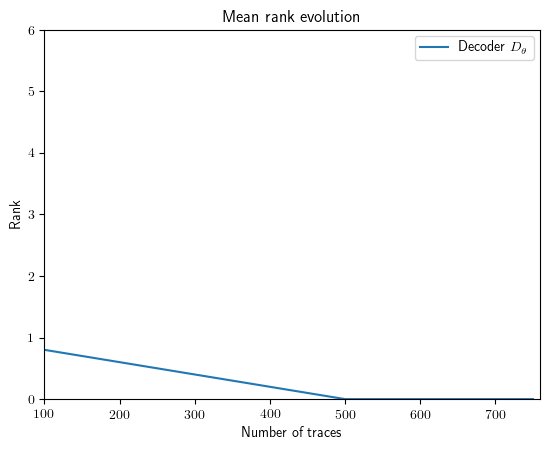

In [8]:
# Plot of averaged rank as a function of the number of traces
plt.plot(traces_number, decoder_results, label=r'Decoder $D_\theta$')
plt.xlim([traces_number[0],traces_number[2]+10])
plt.ylim([0,nb_key_hypotheses + 1])
plt.xlabel('Number of traces')
plt.ylabel('Rank')
plt.title('Mean rank evolution')
plt.legend()
plt.show()

As we can see, the number of traces required to reach a constant rank of $1$ is $500$.